# COVID-19 Open Research Dataset (CORD-19) Topic Modeling

### Table of contents

## Introduction

In [ ]:
# setup
!pip -q install textacy spacy==2.3.5
# mount drive
from google.colab import drive
drive.mount('/content/drive')
# unzip files
!unzip -q /content/drive/MyDrive/CORD-19-research-challenge.zip -d ~/CORD-19-research-challenge/

     |████████████████████████████████| 204kB 5.0MB/s 
     |████████████████████████████████| 10.4MB 9.8MB/s 
     |████████████████████████████████| 1.9MB 46.5MB/s 
     |████████████████████████████████| 481kB 48.4MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
     |████████████████████████████████| 1.1MB 46.9MB/s 
ERROR: textacy 0.11.0 has requirement spacy>=3.0.0, but you'll have spacy 2.3.5 which is incompatible.
Mounted at /content/drive


In [5]:
!pip -q install -U "tmtoolkit[recommended,sklearn]"

ERROR: textacy 0.11.0 has requirement spacy>=3.0.0, but you'll have spacy 2.3.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [32]:
!pip -q install -U matplotlib

     |████████████████████████████████| 10.3MB 5.4MB/s 
ERROR: tmtoolkit 0.10.0 has requirement matplotlib<3.4,>=3.3.0, but you'll have matplotlib 3.4.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [1]:
import numpy as np 
import pandas as pd 
import os
import json
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import spacy
import wordcloud
import pickle

# Change path to data depending on the of your data 
path_to_data = '/root/CORD-19-research-challenge'
path_to_repo = '/content/drive/MyDrive/computing/cord-19-topic-modeling'

# setup other parameters
pdf_json_dir = os.path.join(path_to_data, 'document_parses/pdf_json')
pmc_json_dir = os.path.join(path_to_data, 'document_parses/pmc_json')

# set matplotlib settings
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
print('spacy version:', spacy.__version__)

spacy version: 2.3.5


## Text Representation

Before sending text into algorithms, we need ways to process the text and represent it in a way that computers could understand, i.e. representing it through numbers. We do most of the heavy-lifting of the series of steps to represent text using the `spaCy` package.


In [2]:
nlp = spacy.load('en_core_web_sm', disable = ['tagger', 'parser', 'ner'])

/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


We create a generator object to loop over the document file paths for incremental processing. We also do some light preprocessing like removing citation-related texts and normalizing cases. We use the remaining documents from a separate exploration which removes non-english documents and documents that have > 100,000 characters. 

In [3]:
def text_generator_from_file(file_paths):
    for path in file_paths:
        with open(path) as f:
            js = json.load(f)
            
        texts = []
        for txt in js['body_text']:
            texts.append(txt['text'])         
        joined_txt = ' '.join(texts)
        
        # remove citation-related texts
        removed_citation = re.sub(r'\[\d+\]', '', joined_txt)
        # normalize cases
        lower_case = removed_citation.lower()
        
        yield lower_case
            
file_list = pd.read_pickle(os.path.join(path_to_repo, 'final_document_list.pkl'))
file_list = file_list.apply(lambda x: f'{pdf_json_dir}/{x}.json') 
print('Number of documents:', len(file_list))
doc_generator = text_generator_from_file(file_list)
doc_iter = iter(doc_generator)
    

Number of documents: 140163


### NLP pipeline
 
 We use `spaCy`'s incredible pipeline API to streamline processing of our enormous text data (about 30GB). The language pipeline `en_core_web_sm` includes the usual processes that you might be needing when analyzing texts such as:
 * Tokenization
 * Lemmatization
 * named-entity recognition
 * POS tagging
 
 For this analysis, I limit myself with tokenization and lemmatization. Some description and examples are provided below.


### Tokenization
We numerically represent the documents in this dataset by first breaking up sentences/paragraphs into corresponding tokens in a process trivially called *tokenization*. 

Tokenization can be as simple as splitting a sentence into different words (*word tokenization*), or could be as complex as *byte-pair encoding* which tokenizes sentences using a base vocabulary (usually unicode characters).

For this analysis, I opted to use `spaCy`'s english tokenization algorithm which apart from splitting sentences by the space, has additional tokenization rules, which serves to preserve meaning across different parts of speech.



This is simply achieved by calling the language pipeline, in this case called `nlp`.

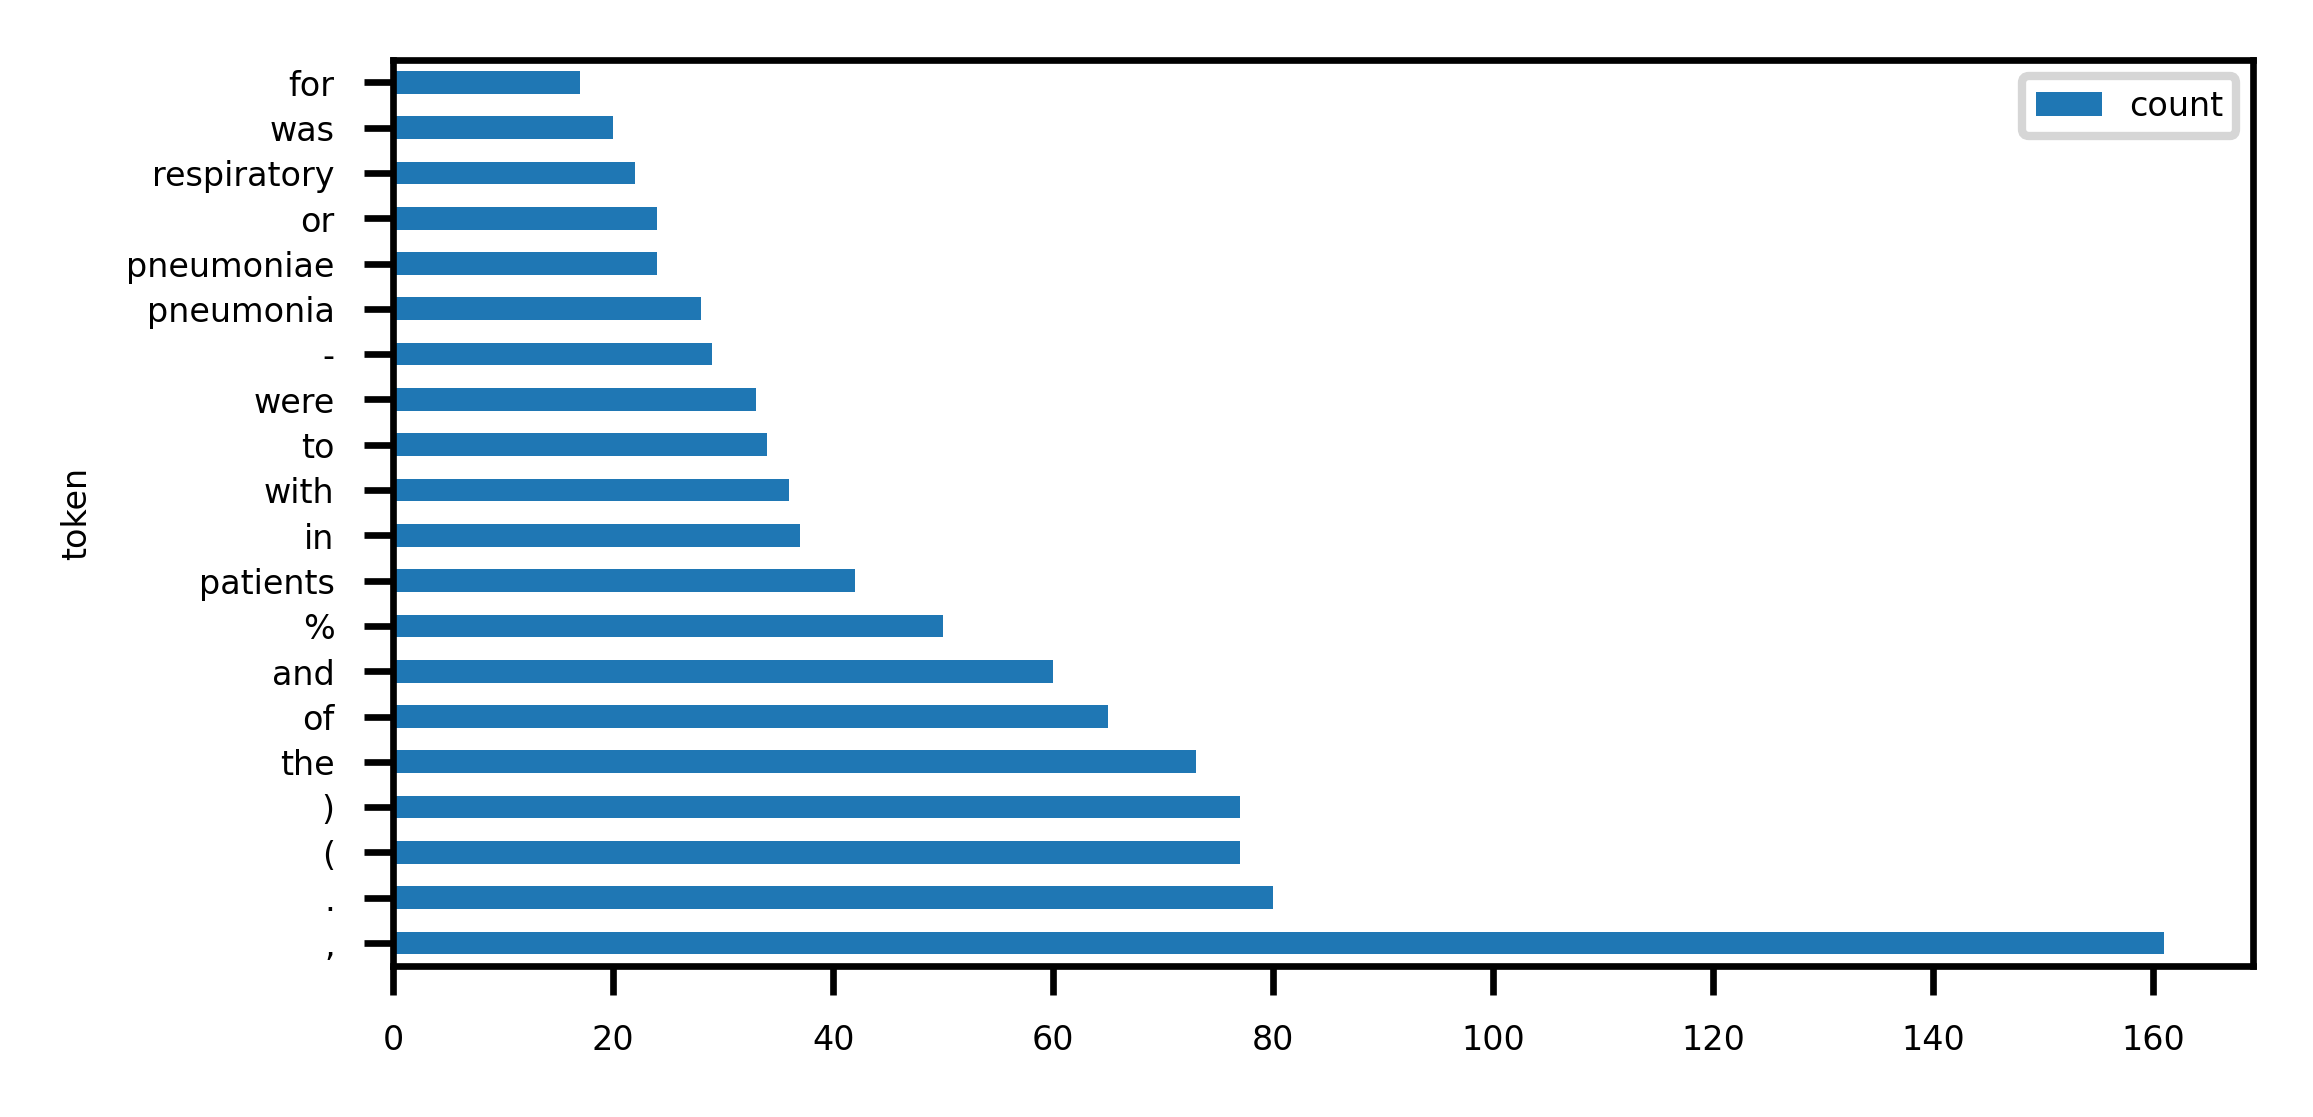

In [4]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'font.size': 4})
doc = nlp(next(doc_iter))
tokens = [token.text for token in doc]
counter = Counter(tokens)
most_common = pd.DataFrame(counter.most_common(20), columns = ['token','count'])

fig, ax = plt.subplots(1, figsize = (4,2))
most_common.plot.barh('token', 'count', ax = ax)
plt.show()

We can see above that the text was broken down into its constituent words. There are still punctuation marks left, and some spaces too. We will be addressing this in the real pipelining of processes. 

### Lemmatization

The process of *lemmatization* intends to reduce a word to its base form. This process is often related to *stemming*, but is a different beast all together. The difference between two is that lemmatization involves knowing the context of a word, while stemming does not take this into account.

The `spaCy` framework has its own english lemmatizer, which in itself is a set of rules. There are also times when we need a custom lemmatizer. This can be seamlessly done in `spaCy`.

In [ ]:
text = 'we are going to meet in a meeting tomorrow during a meet'
doc = nlp(text)
[token.lemma_ for token in doc]

['we',
 'be',
 'go',
 'to',
 'meet',
 'in',
 'a',
 'meet',
 'tomorrow',
 'during',
 'a',
 'meet']

Shown above, we can see that although the stem of *meeting* is *meet*, this was not normalized since the algorithm accounts for situations when words should not be reduce when it is a certain part of speech. Which in this case is a noun.

### Combined processing using pipeline

We now use the `pipe` API to sequentially apply the tokenizer and lemmatizer to the set of documents. We also look to remove uninformative words/characters such as stop words, punctuations, and white spaces.

We use here the `DocBin` module to serialize documents for later use.

In [ ]:
#doc_bin = spacy.tokens.DocBin(attrs = ['LEMMA', 'ENT_IOB', 'ENT_TYPE'], store_user_data = False)
from collections import Counter
doc_generator = text_generator_from_file(file_list[:])
doc_iter = iter(doc_generator)
doc_word_count_dict = {}
for i, _doc in enumerate(tqdm(nlp.pipe(doc_iter), total = len(file_list))):
    words = []
    for token in _doc:
        if not token.is_stop | token.is_space | token.is_punct:
            # we use the lemmatized word for downstream processes
            words.append(token.lemma_)
    doc_word_count_dict[i] = Counter(words) 
pickle.dump(doc_word_count_dict, open('/content/drive/MyDrive/doc_word_count_dict.pkl','wb'))
drive.flush_and_unmount()    

In [47]:
# uncomment to load the preprocessed word count dict
doc_vocab2count = pickle.load(open(os.path.join(path_to_repo, 'doc_word_count_dict.pkl'), 'rb'))

### Vocabulary creation

In [48]:
token_list = []
for idx, docs in tqdm(doc_vocab2count.items()):
  token_list.append(list(docs.keys()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


remove very rare words depending on parameter `min_doc_count`

In [49]:
min_doc_count = 10
all_tokens = [token for tokens in token_list for token in tokens]
all_tokens_count = Counter(all_tokens)
print(f"There are {len(all_tokens_count)} unique tokens.")
remaining_tokens = [k for k, v in all_tokens_count.items() if v >= min_doc_count]
print(f"There are only {len(remaining_tokens)} remaining tokens") 

There are 2204537 unique tokens.
There are only 161296 remaining tokens


In [50]:
remaining_tokens[:10]

['mycoplasma',
 'pneumonia',
 'common',
 'cause',
 'upper',
 'low',
 'respiratory',
 'tract',
 'infection',
 'remain']

In [55]:
doc_token2idx = {k :i for i, k in enumerate(remaining_tokens)}
dict(list(doc_token2idx.items())[:5])

{'cause': 3, 'common': 2, 'mycoplasma': 0, 'pneumonia': 1, 'upper': 4}

Convert tokens to index and prepare data for the document-term matri

In [66]:
row_ind = []
col_ind = []
data = []
for idx, tokens in tqdm(doc_vocab2count.items()):
  for k, v in tokens.items():
    if k in doc_token2idx:
      col_ind.append(doc_token2idx[k])
      row_ind.append(idx)
      data.append(v)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


### Creating the document-term matrix

In [69]:
from scipy.sparse import csr_matrix
dtm = csr_matrix((data, (row_ind, col_ind)), shape = (len(doc_vocab2count), len(remaining_tokens)))
dtm.shape

(140163, 161296)

In [71]:
pickle.dump(dtm, open(os.path.join(path_to_repo, "final_dtm.pkl"), 'wb'))

## Fitting the LDA Model using `sklearn`

In [2]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [75]:
ldamodel = LDA(n_components=5, random_state= 0, verbose=1)
ldamodel.fit(dtm)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=1)

In [81]:
pickle.dump(ldamodel, open(os.path.join(path_to_repo, "ldamodel-5topics.pkl"), "wb"))

In [5]:
# uncomment to load model and dtm
ldamodel = pickle.load(open(os.path.join(path_to_repo, "ldamodel-5topics.pkl"), "rb"))
dtm = pickle.load(open(os.path.join(path_to_repo, "final_dtm.pkl"), "rb"))
output = ldamodel.transform(dtm)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [79]:
output

array([[1.70494355e-04, 8.24115040e-01, 1.76465846e-04, 1.75366249e-01,
        1.71750755e-04],
       [1.28223341e-04, 1.73386663e-01, 1.27603807e-04, 9.17356609e-02,
        7.34621849e-01],
       [6.40232357e-05, 8.42053402e-03, 6.40694083e-05, 6.85942058e-02,
        9.22857168e-01],
       ...,
       [8.65094108e-01, 4.63302933e-02, 8.76449537e-02, 4.59138300e-04,
        4.71506682e-04],
       [1.95350522e-01, 4.07338674e-01, 3.97067399e-01, 1.22527432e-04,
        1.20877297e-04],
       [9.98361941e-01, 4.10490426e-04, 4.09461835e-04, 4.10004710e-04,
        4.08102467e-04]])

In [84]:
output.shape

(140163, 5)

In [80]:
perplexity = ldamodel.perplexity(dtm)
perplexity

3255.4661272888343

## Interpretation and Visualization of Results

In [6]:
topic_contribution = pd.DataFrame({'topic':np.argmax(output, axis =1)})
topic_contribution['prob'] = np.max(output, axis = 1)
topic_contribution.head()

,topic,prob
0,1,0.824115
1,4,0.734622
2,4,0.922857
3,4,0.528080
4,4,0.914388


<AxesSubplot:xlabel='Topic'>

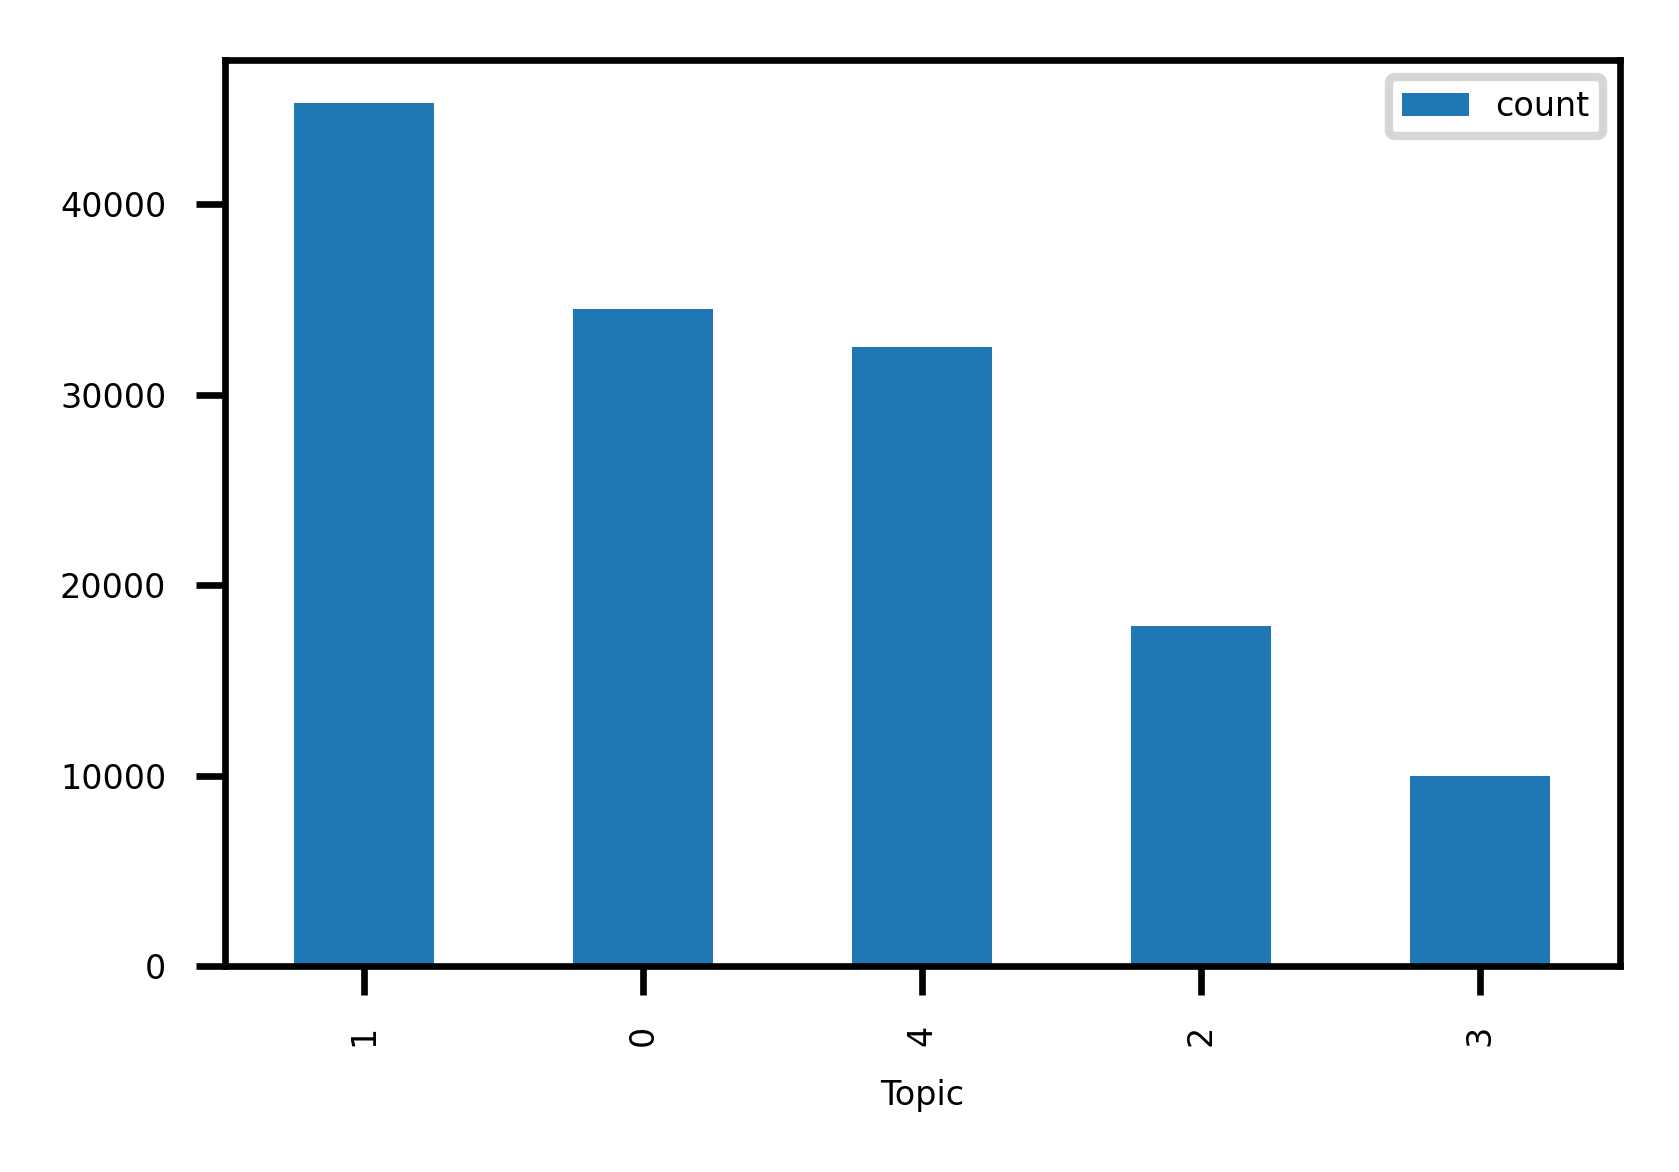

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3,2))
topic_contribution.topic.value_counts().reset_index() \
.rename(columns = {'index': 'Topic', 'topic': 'count'}) \
.plot.bar('Topic', 'count', ax = ax)


In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer()
tf_matrix = tf.fit_transform(dtm)

### getting the top words per topic

In [26]:
summed_counts = []
for _topic in range(5):
  indices = topic_contribution[topic_contribution.topic == _topic].index
  sum_counts = dtm[indices, :].sum(axis = 0)
  summed_counts.append(sum_counts)
  print(sum_counts.shape)
summed_counts = np.concatenate(summed_counts, axis = 0)


(1, 161296)
(1, 161296)
(1, 161296)
(1, 161296)
(1, 161296)


In [66]:
top_n = 10
top_n_index = np.array(summed_counts.argsort(axis = 1)[:, -top_n:])
top_n_words = []
for i in range(top_n_index.shape[0]):
  for wordidx in top_n_index[i]:
    top_n_words.append(
        tuple([str(i) , remaining_tokens[wordidx], summed_counts[i, wordidx]])
        )

top_n_words = pd.DataFrame(top_n_words, columns = ['Topic', 'Word', 'Count'])

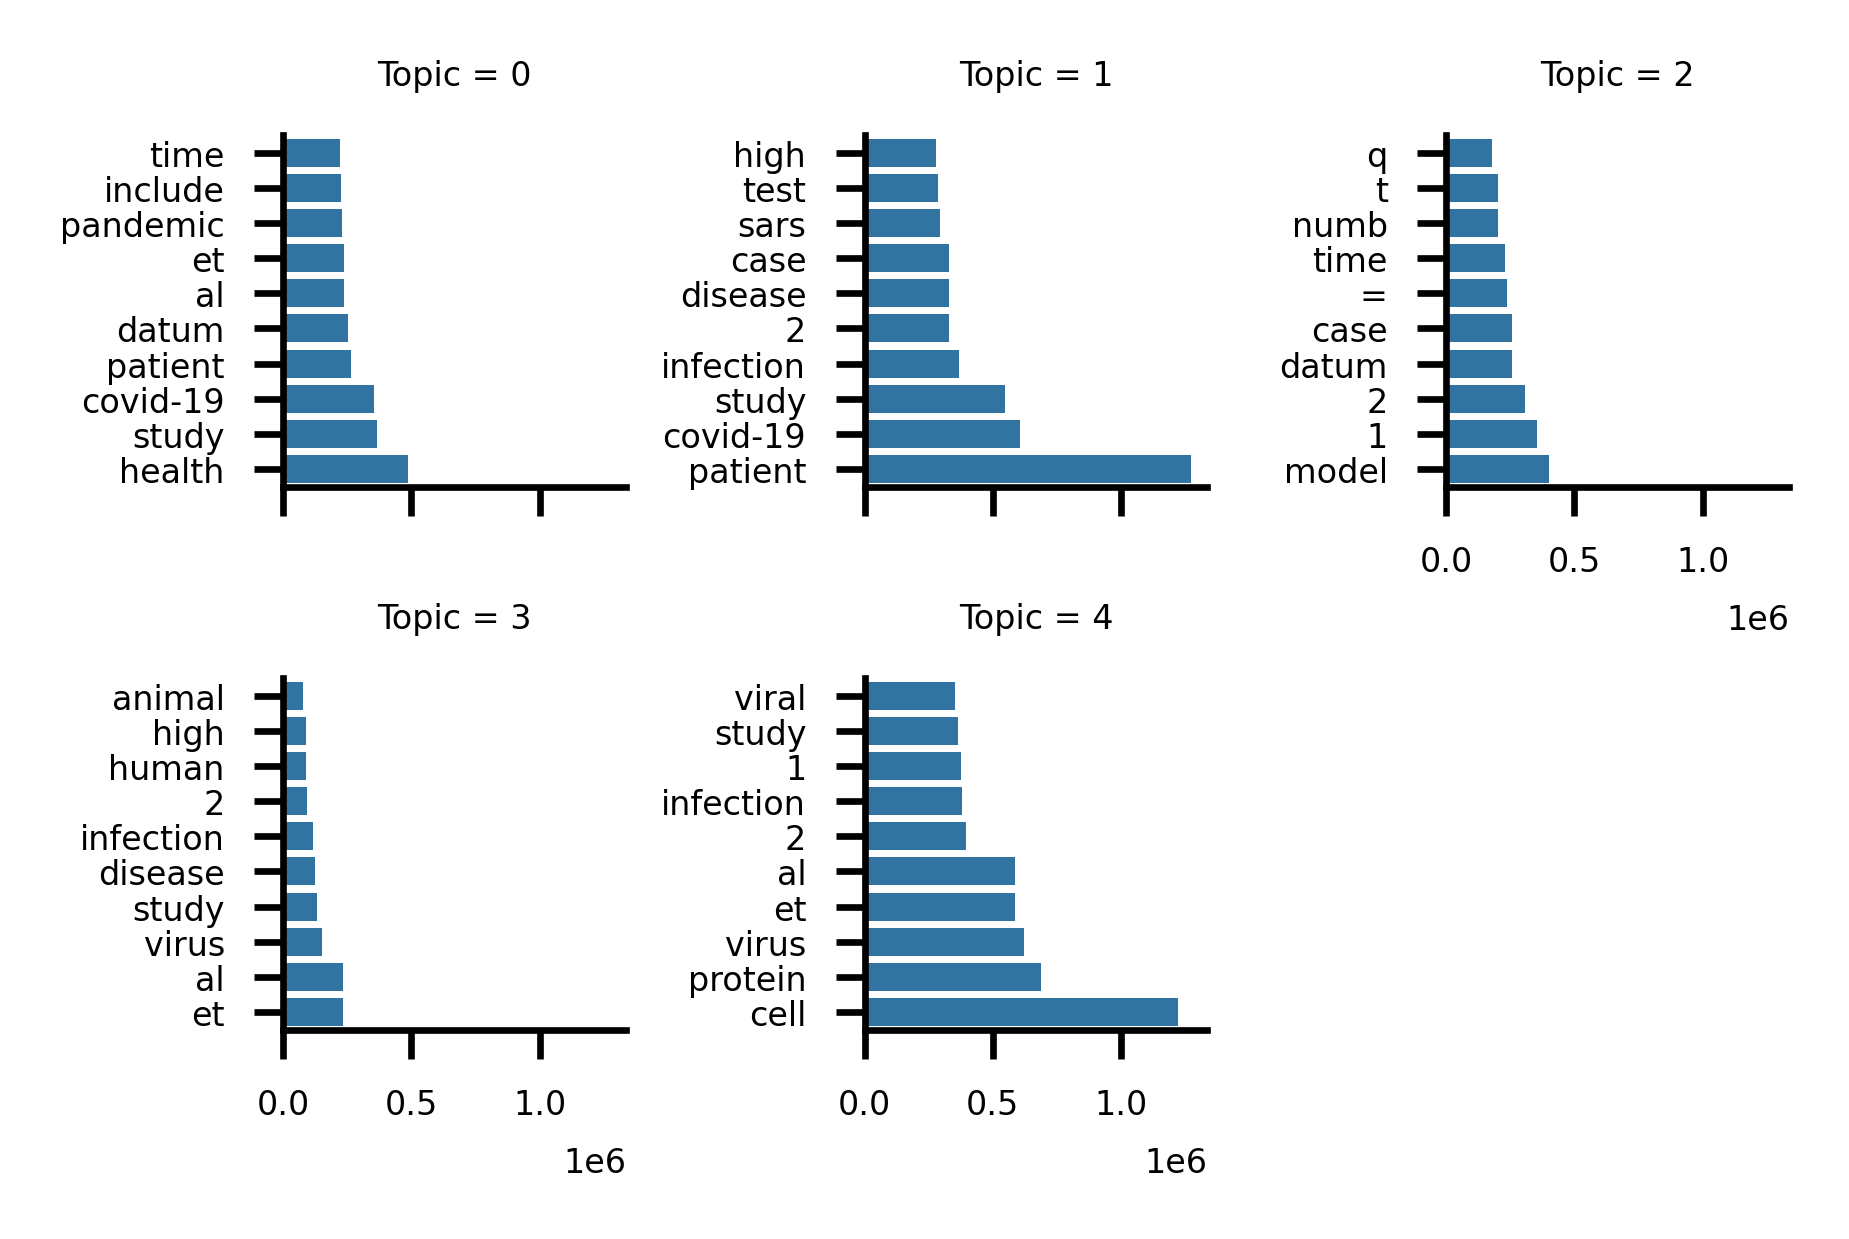

In [84]:
g = sns.FacetGrid(top_n_words,col = "Topic", col_wrap = 3, sharex = True, sharey = False, height=1, aspect = 1)
g.map_dataframe(sns.barplot, x = "Count", y = "Word", orient = "h")
plt.show()

### Getting top words by tf-idf